In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import csv
import json
import os 
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import shutil
from importlib import reload
from IPython.display import Image, display, HTML

import pprint 
pp = pprint.PrettyPrinter(indent=4)

In [3]:
import config
import utils

import raw_log_types
import results
import tasks
import task_results
from main import VbsVis

from constants import *

In [4]:
%autoreload 2

In [13]:
vbs = VbsVis()
#VbsVis.flush_cache()
#VbsVis.help()

Loading cached instance from ./__cache__/vbs.pkl...


In [15]:
vbs._tasks

AttributeError: 'VbsVis' object has no attribute '_tasks'

In [6]:
VbsVis.flush_cache()
vbs.parse_team("SOMHunter", 
                  ["sh-patrik", "sh-vit"], 
                  verbose=True, 
                  validate_fix=False,
                  generate_DRES=False
                 )
# vbs.parse_team("CollageHunter", 
#                   ["collage-jakub", "collage-premek"], 
#                   verbose=True, 
#                   validate_fix=False, 
#                   generate_DRES=False
#                  )
# vbs.parse_team("LegacySOMHunter", 
#                   ["legacy-tereza", "legacy-franta-tomas"], 
#                   verbose=True, 
#                   validate_fix=False, 
#                   generate_DRES=False
#                  )

VbsVis.cache(vbs)

Error while deleting directory
TEAM: SOMHunter

%%% PARSING %%%
---
+++ sh-patrik +++ 
DATA: ./data/sh-patrik 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ sh-vit +++ 
DATA: ./data/sh-vit 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ sh-patrik +++ 
DATA: ./data/sh-vit 

	--- PARSING SUMMARY. ---
	--- DONE. ---
	--- PARSING TASK RESULTS. ---
	--- DONE. ---
---
+++ sh-vit +++ 
DATA: ./data/sh-patrik 

	--- PARSING SUMMARY. ---
	--- DONE. ---
	--- PARSING TASK RESULTS. ---
	--- DONE. ---
%%% DONE! %%%


In [7]:
def plot_timelines(self, tasks=None, teams=None, users=None):      
    
    for t in self.tasks().tasks():
        t_name = t.name()
        if ((tasks != None) and (not (t_name in tasks))):
            continue
                
        
        print(f"\t%%% {t_name} %%%")
        
        t_dur = t.duration()
        
        times = {}
        vals_videos = {}
        vals_frames = {}
        
        result_num_limit = {}
        
        keys_corr_submits = {}
        keys_incorr_submits = {}
        submits_indeterminate = {}
        submits_timeout = {}
        submits_server_lag = {}
        submits_logged_out = {}
        
        d_keys = {}
        d_vals = {}
        
        # Flags
        flags = {}
        
        task_results = self.task_results().task_results_arrays()
        user_submits = self.task_results().task_submits_arrays()
        
        for team, team_dict in task_results.items():
            if ((teams != None) and (not (team in teams))):
                continue

            print(f"\t--- {team} ---")
            
            this_users = []
            
            for user, user_results in team_dict.items():
                if ((users != None) and (not (user in users))):
                    continue

                print(f"\t\t--- {user} ---")
                this_users.append(user)

                user_task_results = user_results[t_name]
                user_task_submits = user_submits[team][user][t_name]
                
                # Input data
                
                tt = list(map(lambda x: x / 1000.0,user_task_results.elapsed()))
                times[user] = tt
                
                
                vals_videos[user] = user_task_results.vid()
                vals_frames[user] = user_task_results.fr()
                flags[user] = user_task_results.c()
                result_num_limit[user] = user_task_results.reported()

                submits = list(zip(user_task_submits.elapsed(), user_task_submits.c()))
                
                keys_corr_submits[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "T", submits)))
                keys_incorr_submits[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "F", submits)))
                
                submits_indeterminate[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "I", submits)))
                submits_timeout[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "TIMEOUT", submits)))
                submits_server_lag[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "SERVER_LAG", submits)))
                submits_logged_out[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "LOGGED_OUT", submits)))
                

#             pp.pprint(times)
#             pp.pprint(vals_videos)
#             pp.pprint(vals_frames)
#             pp.pprint(flags)
#             pp.pprint(result_num_limit)
#             pp.pprint(keys_corr_submits)
#             pp.pprint(keys_incorr_submits)
            #raise Exception("SSS")


            # Canvas size
            fig, ax = plt.subplots(figsize=(16,4))

            # Title
            ax.set_title(t_name, y=1.0)

            #ax.yaxis.set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(True)
            ax.spines['top'].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')


            # Set y to log scale
            plt.yscale("log")

            # Set y axis range
            plt.ylim(1, 40000)
            ax.set_xlim(xmin=0, xmax=430)


            iter = 0
            for member_ID in this_users:
                
                
                ##########################
                # Draw video & frame pos
                ##########################
                #
                # Video positions
                #
                plt.step(times[member_ID], vals_videos[member_ID], where='post', label='post', color=COLORS[iter] , linewidth="2")

                #
                # Frame positions
                #
                plt.step(times[member_ID], vals_frames[member_ID], where='post', label='post', color=COLORS[iter], linestyle=':', linewidth="4")

                #
                # Limit of send results
                #
                plt.step(times[member_ID], result_num_limit[member_ID], where='post', label='post', color=COLORS[iter], linestyle='dashdot', linewidth="1")

#                 ##########################
#                 # Draw display switches
#                 ##########################

#                 if (team_ID in task["displays"] and member_ID in task["displays"][team_ID]):
#                     displ_types = task["displays"][team_ID][member_ID][1]

#                     for state in displ_types:
#                         #plt.axvspan(i, i+.5, facecolor='b', alpha=0.5)

#                         if (state.display == "R"):
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_random[member_ID])
#                         elif state.display == "T":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_topn[member_ID])
#                         elif state.display == "N":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_topknn[member_ID])
#                         elif state.display == "S":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_som[member_ID])
#                         elif state.display == "D":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_detail[member_ID])
#                         elif state.display == "P":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_replay[member_ID])


                ##########################
                # Draw event markers
                ##########################

#                 iii = 0
#                 for f in flags[member_ID]:

#                     keys = f.keys()
#                     rich = f["is_knn"] or f["is_localized"] or f["is_color"] or f["is_bayes"]or f["is_text"]


#                     if not rich:
#                         cust_marker = {"marker": r"$?$", "markerfacecolor": COLORS[member_ID], "markeredgecolor": COLORS[member_ID], "markersize": 12}
#                         plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **cust_marker)

#                     #
#                     # Is KNN
#                     #
#                     if (f["is_asr"]):
#                         plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **asr_marker)


#                      #
#                     # Is KNN
#                     #
#                     if (f["is_knn"]):
#                         if (f["is_knn"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **knn_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **knn_marker_bkg_red)

#                     #
#                     # Is localized object
#                     #
#                     if (f["is_localized"]):
#                         if (f["is_localized"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **localized_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **localized_marker_bkg_red)
#                     #
#                     # Is color sketch
#                     #
#                     if (f["is_color"]):
#                         if (f["is_color"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **color_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **color_marker_bkg_red)





#                     #
#                     # Is Bayes rerank
#                     #
#                     if (f["is_bayes"]):
#                         if (f["is_bayes"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **bayes_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **bayes_marker_bkg_red)

#                     #
#                     # (Temporal) Text query
#                     #
#                     if (f["is_text"]):

#                         if ("text_type" in f and f["text_type"] != None):
#                             label = ""

#                             if f["text_type"]["concept"]:
#                                 label += "C,"

#                             if f["text_type"]["caption"]:
#                                 label += "P,"

#                             if f["text_type"]["ocr"]:
#                                 label += "O,"

#                             if (label != ""):
#                                 cust_marker = {"marker": r"$t$", "markerfacecolor": "#000000", "markeredgecolor": "#000000", "markersize": 12, "label":label}                        
#                                 plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **cust_marker)
#                                 plt.text(times[member_ID][iii] + 2, vals_videos[member_ID][iii], label, fontsize=10)




#                         else:
#                             if (f["is_text"] == 1):
#                                 if (f["is_temporal"]):
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **temp_marker)
#                                 else:
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **text_marker)
#                             else:
#                                 if (f["is_temporal"]):
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **temp_marker_red)
#                                 else:
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **text_marker_red)




#                     iii +=1

                ##########################
                # Draw the end of the task
                ##########################
                plt.axvline(x=t_dur, color='r', linestyle=':', linewidth="10")

                ##########################
                # Draw submits
                ##########################
                
                # Correct
                for s in keys_corr_submits[member_ID]:
                    plt.axvline(x=s, color='g', linewidth="2")

                # Incorrect
                for s in keys_incorr_submits[member_ID]:
                    plt.axvline(x=s, color='darkorange', linewidth="2")
                    
                # Indeterminate
                for s in submits_indeterminate[member_ID]:
                    plt.axvline(x=s, color='grey', linewidth="2")
                    
                # Timeout
                for s in submits_timeout[member_ID]:
                    plt.axvline(x=s, color='r', linewidth="4")
                    
                # Lag
                for s in submits_server_lag[member_ID]:
                    plt.axvline(x=s, color='fuchsia', linewidth="4")
                    
                # Logged out
                for s in submits_logged_out[member_ID]:
                    plt.axvline(x=s, color='b', linewidth="4")
                                   
                iter += 1
            
            #ax.get_yaxis().set_ticklabels([])
            plt.show()
            
            
        
    #plt.savefig(CONFIG.BASE_DIR + "timelines.png")

	%%% 01_v21-1 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


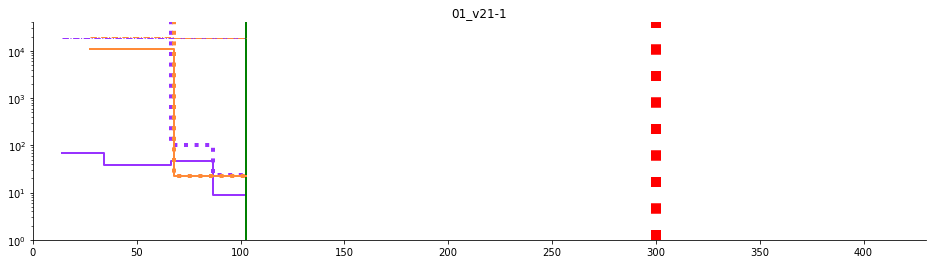

	%%% 02_a21-5 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


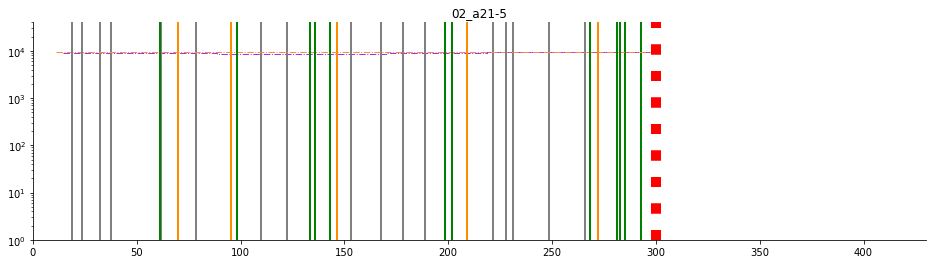

	%%% 03_t21-1 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


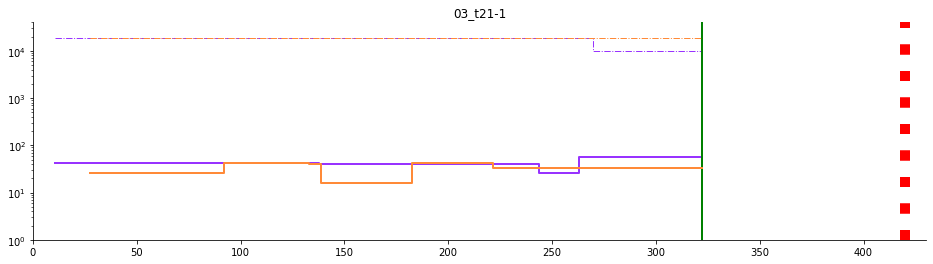

	%%% 04_v21-2 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


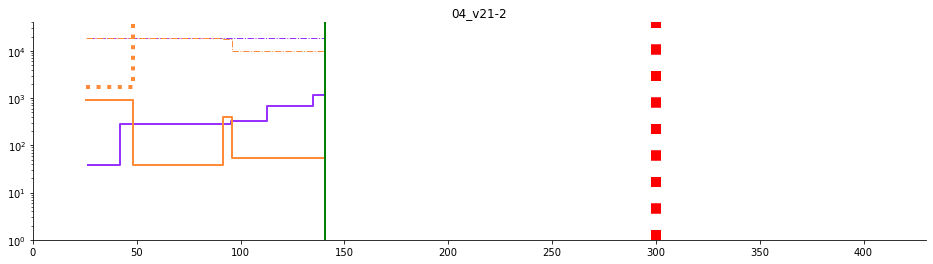

	%%% 05_a21-9 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


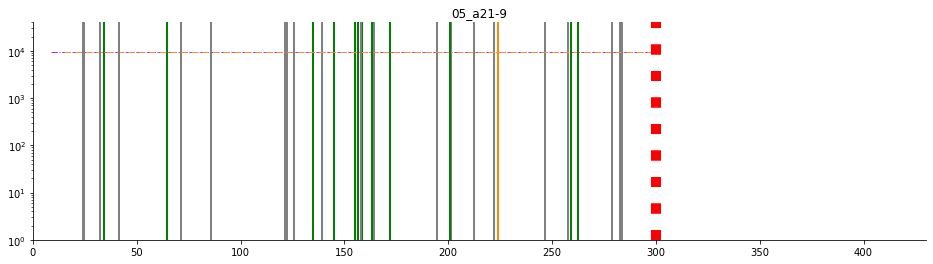

	%%% 06_t21-2 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


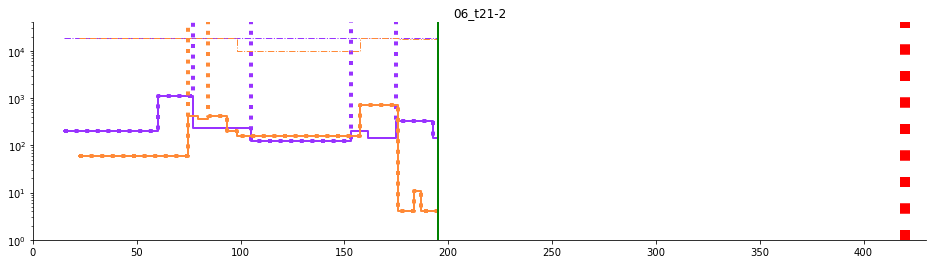

	%%% 07_v21-3 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


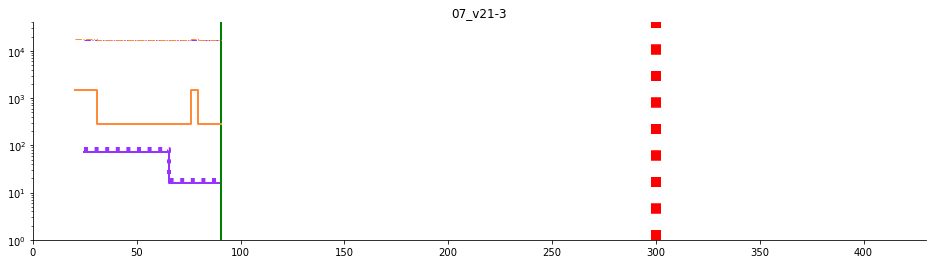

	%%% 08_t21-7 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


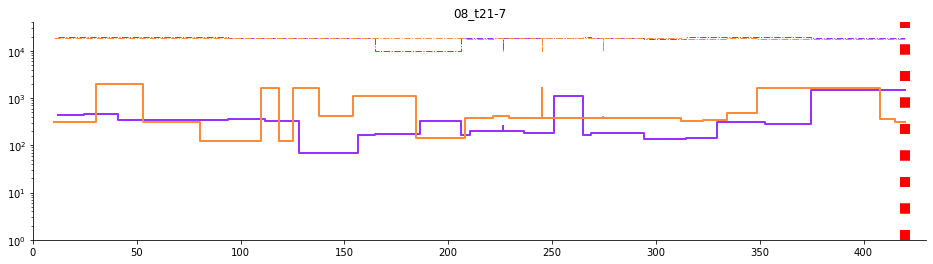

	%%% 09_a21-7 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


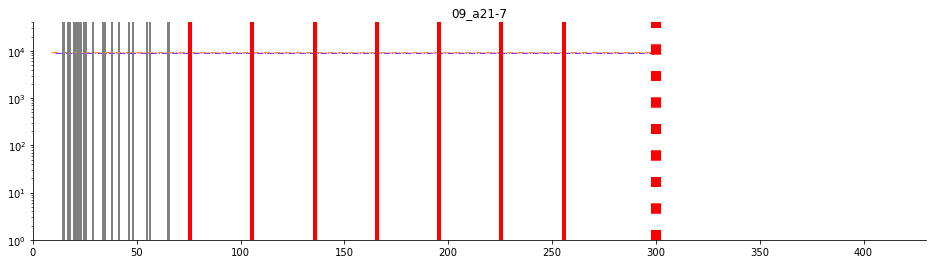

	%%% 10_a21-8 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


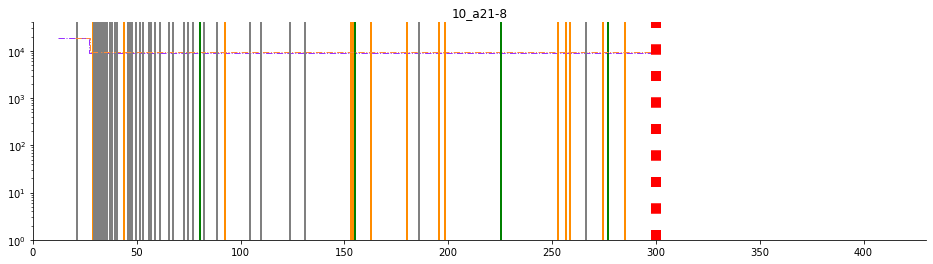

	%%% 11_v21-4 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


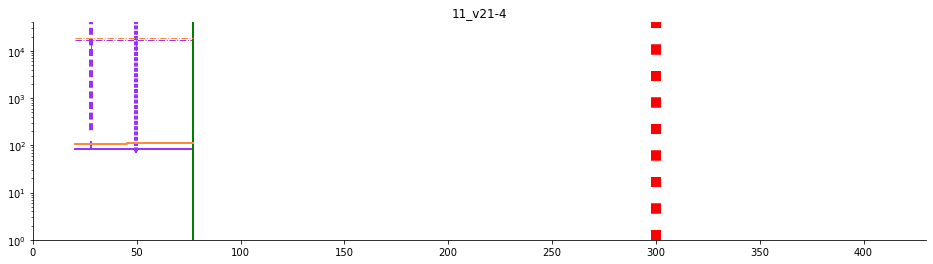

	%%% 12_t21-3 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


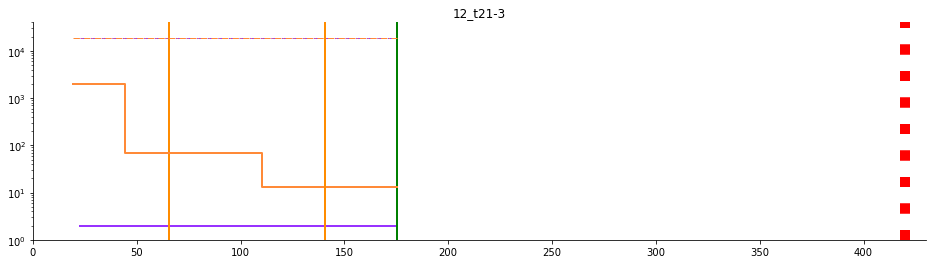

	%%% 13_a21-1 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


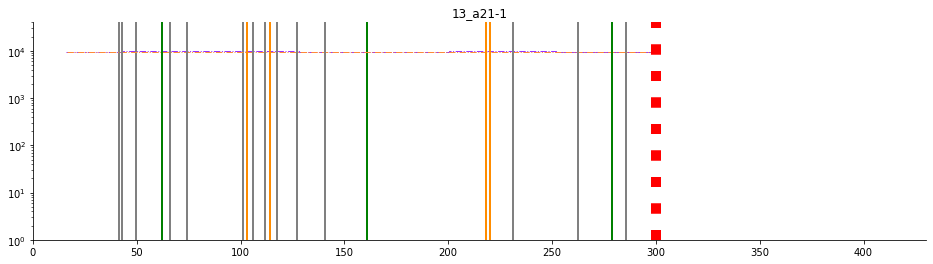

	%%% 14_t21-4 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


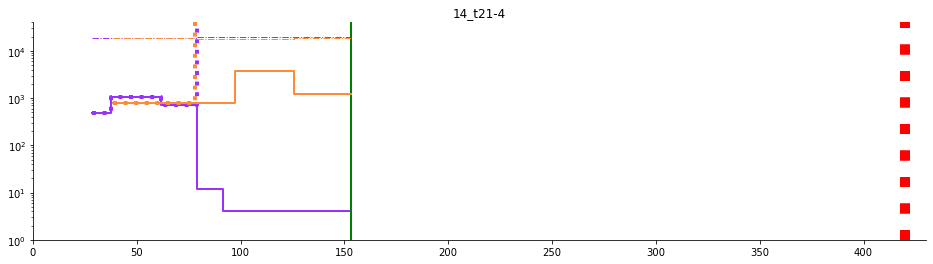

	%%% 15_v21-5 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


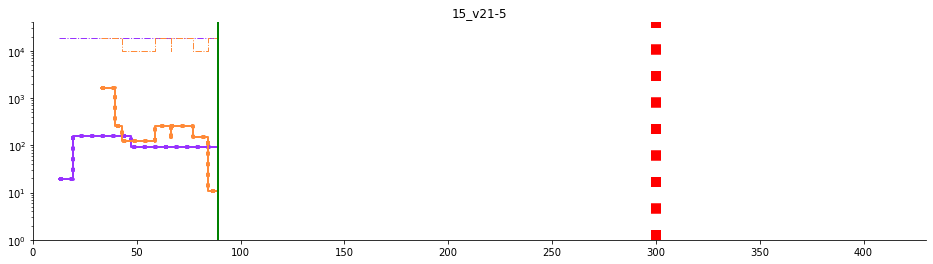

	%%% 16_t21-5 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


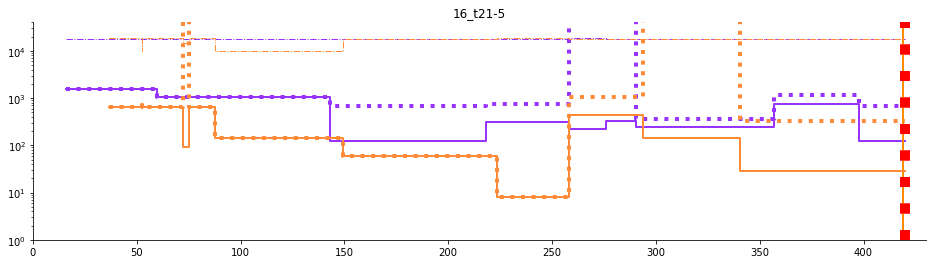

	%%% 17_v21-6 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


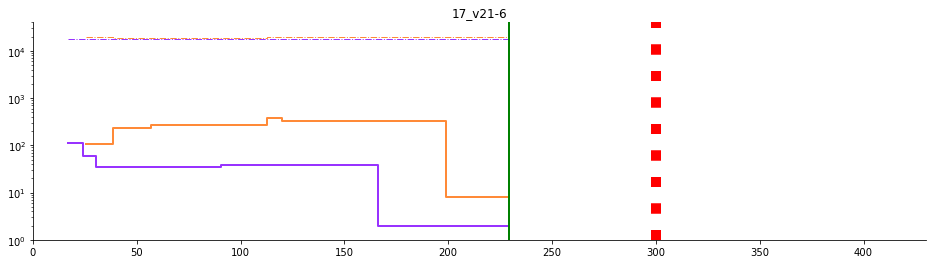

	%%% 18_v21-7 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


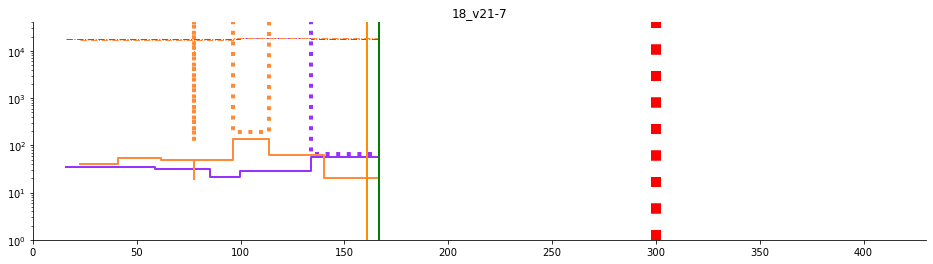

	%%% 19_a21-2 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


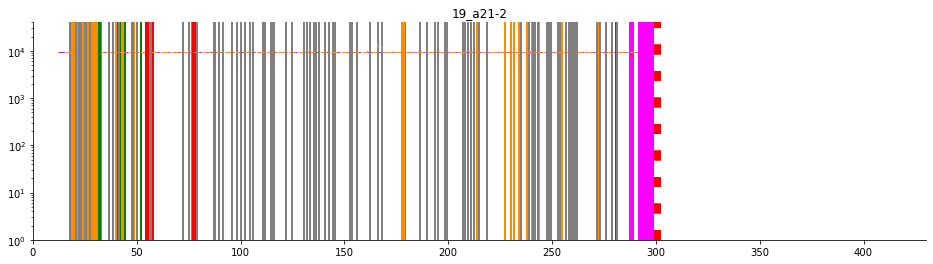

	%%% 20_v21-8 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


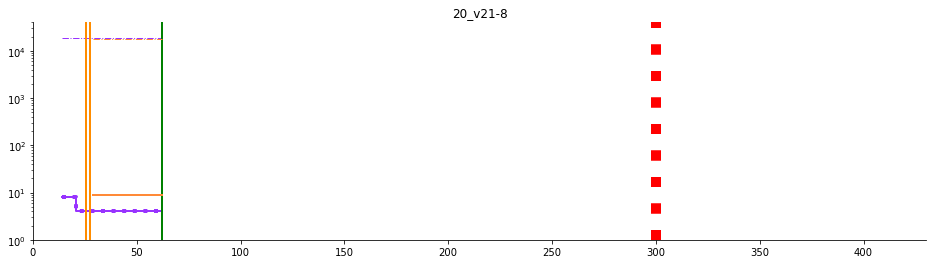

	%%% 21_v21-9 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


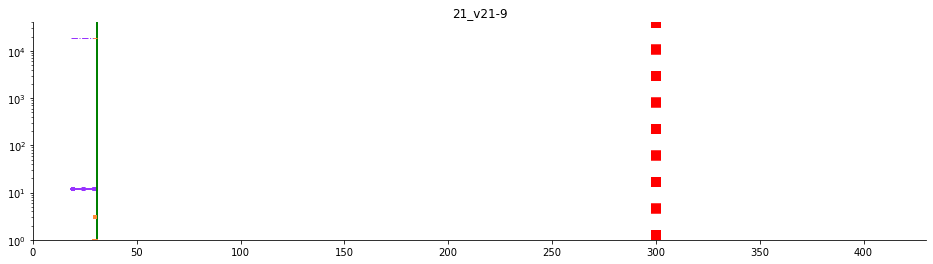

	%%% 22_v21-10 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


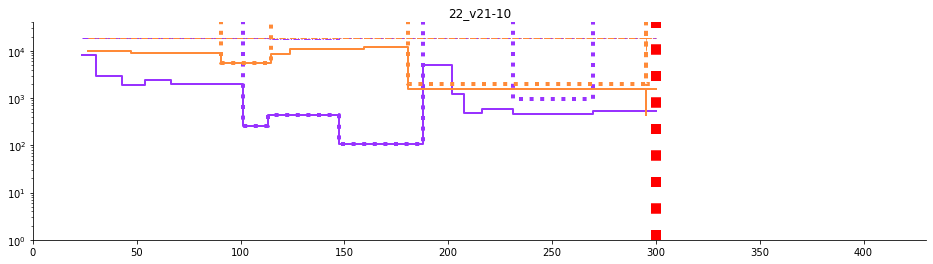

	%%% 23_v21-11 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


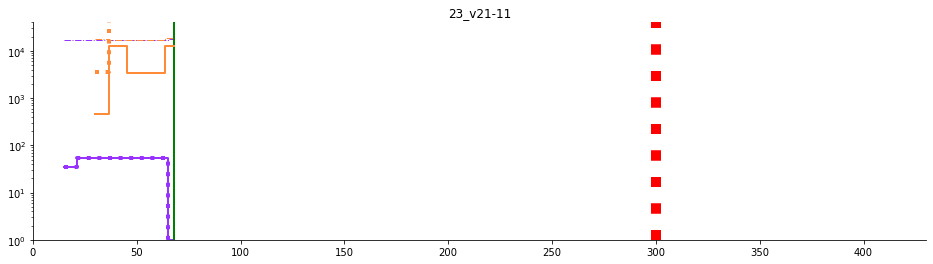

	%%% 24_v21-12 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


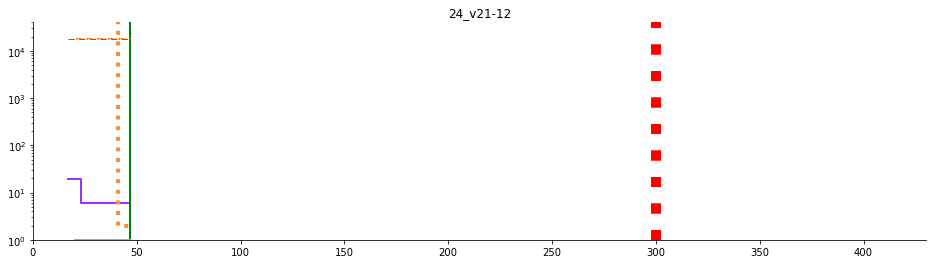

	%%% 25_v21-13 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


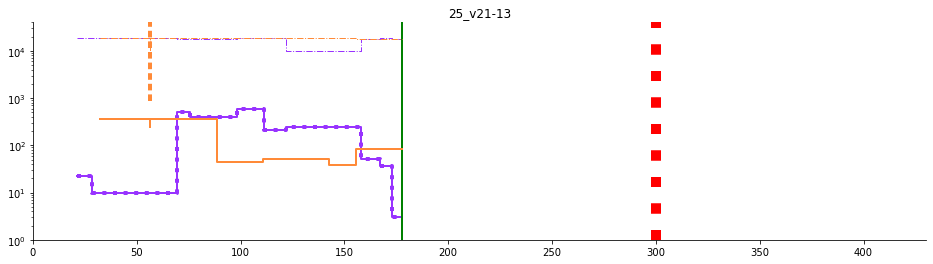

	%%% 26_a21-3 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


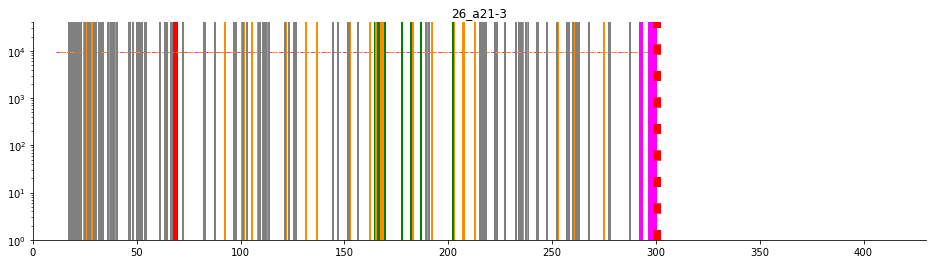

	%%% 27_v21-14 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


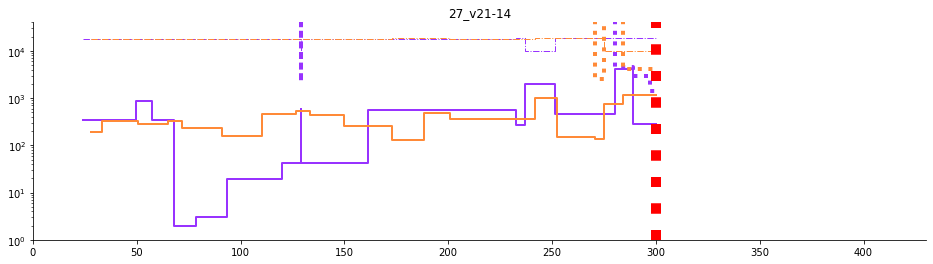

	%%% 28_a21-10 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


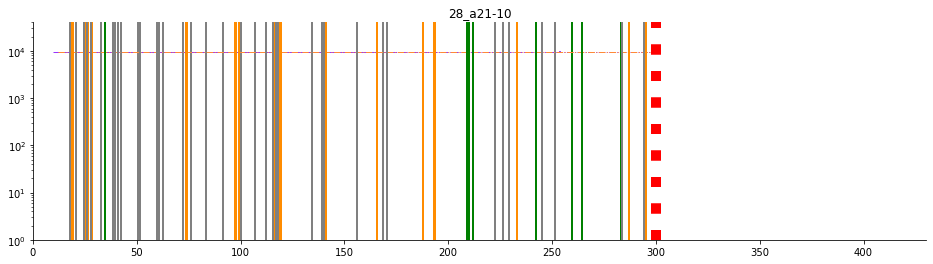

	%%% 29_v21-15 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


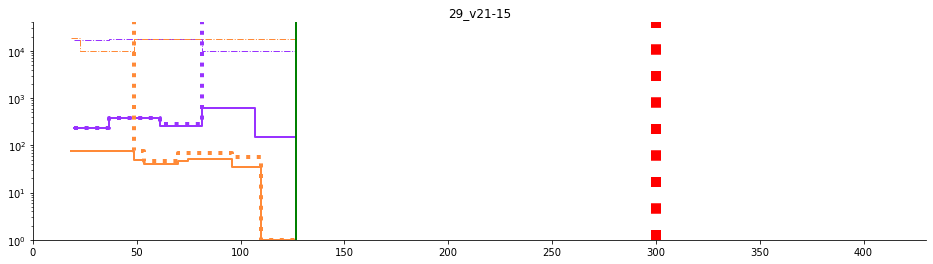

	%%% 30_a21-4 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


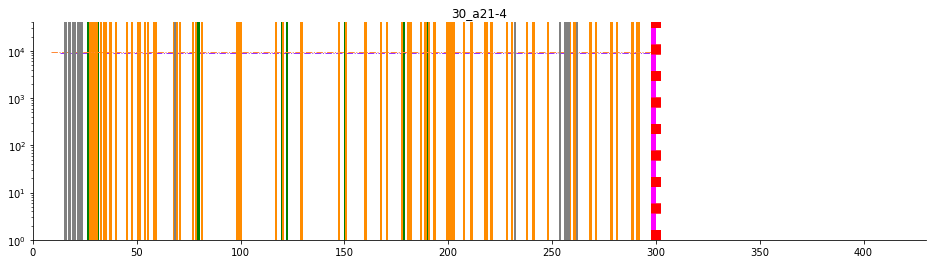

	%%% 31_v21-16 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


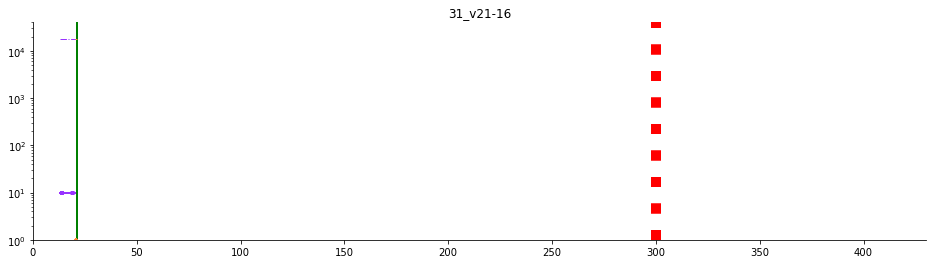

	%%% 32_v21-17 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


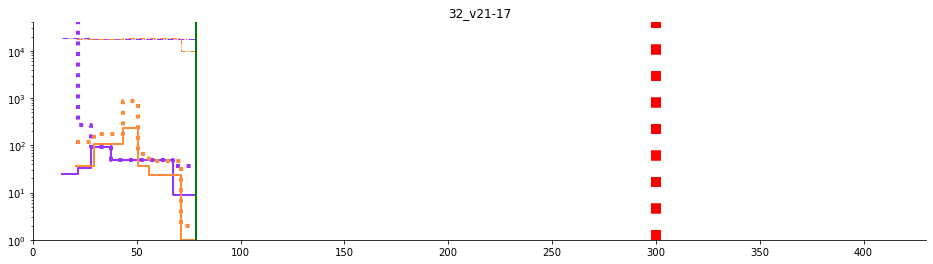

	%%% 33_a21-11 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


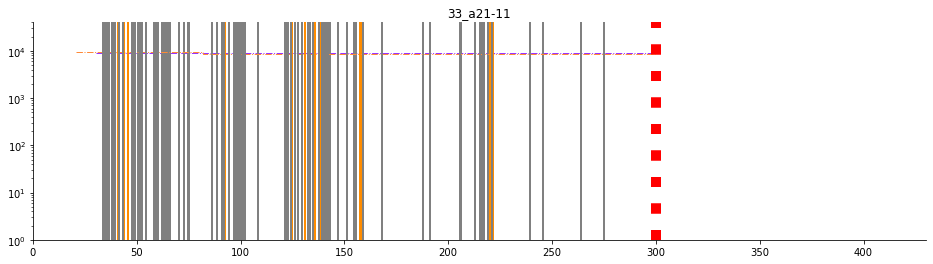

	%%% 34_v21-18 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


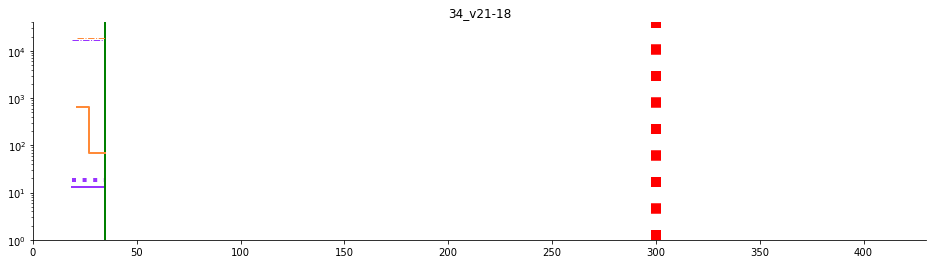

	%%% 35_v21-19 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


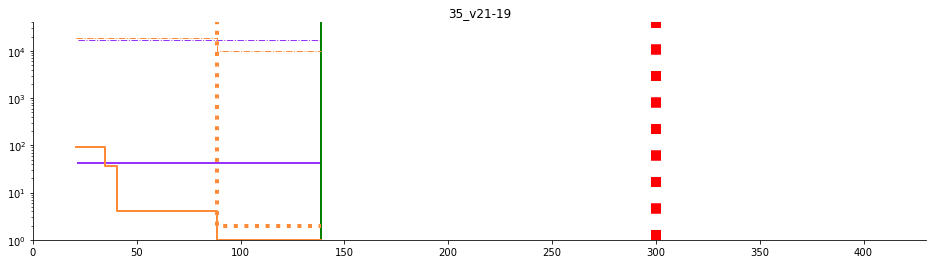

	%%% 36_v21-20 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


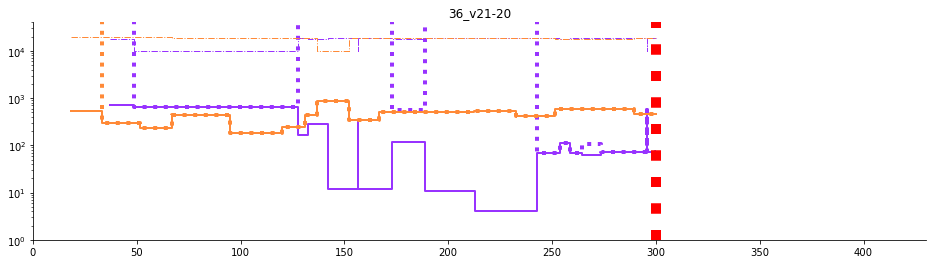

	%%% 37_a21-6 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


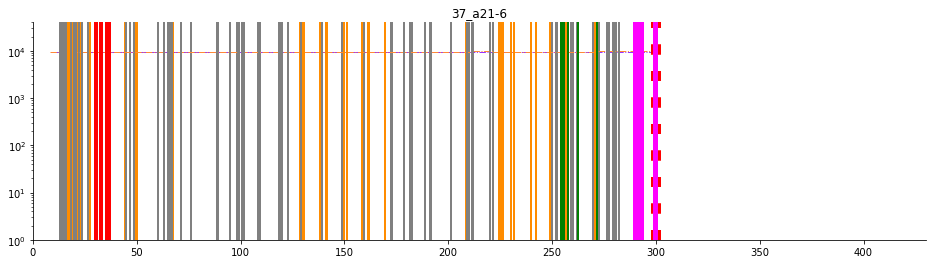

	%%% 38_v21-21 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


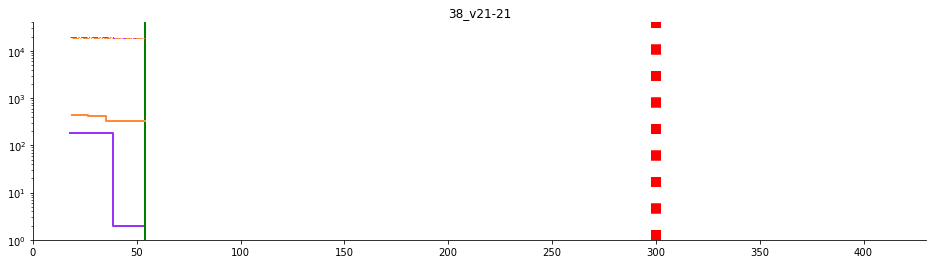

In [8]:
plot_timelines(vbs)


# Info queries

In [9]:
vbs.print_tasks()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_tasks(["09_a21-7"])

***############################***
***###*** VBS 2021 TASKS ***###***
***############################***
>>>>>>>>>>>>> STATS <<<<<<<<<<<<<<<<
Number of tasks: 38
Unique video IDs: 
88, 1162, 1939, 2034, 2224, 2464, 2519, 3085, 3317, 3331, 3870, 3885, 4035, 4178, 4225, 4316, 4888, 4979, 5146, 5531, 6228, 6246, 6561, 6827, 6979, 7116, 7421, 
>>>>>>>>>>>>> TASKS <<<<<<<<<<<<<<<<
	*** Task ***
	name: 01_v21-1
	type: V
	timestamps: (1624277458765, 1624277758765)
	times: (21-06-2021 14:10:58, 21-06-2021 14:15:58)
	text: None
	target: *** TaskTarget ***
		video_ID: 4178
		interval: (1875.0, 2300.0)




------------------------------------
	*** Task ***
	name: 02_a21-5
	type: A
	timestamps: (1624277828154, 1624278128154)
	times: (21-06-2021 14:17:08, 21-06-2021 14:22:08)
	text: Find shots of a person holding or waving a flag.
	target: None

------------------------------------
	*** Task ***
	name: 03_t21-1
	type: T
	timestamps: (1624278204021, 1624278624021)
	times: (21-06-2021 14:23:24, 21-06-2021 14:30:24)
	text: Graffity artists spraying purple outline of the letters RTH. Letters are white/green on a wall with a blueish graffity on the left. He wears a blue jacket over a green hoodie.

	target: *** TaskTarget ***
		video_ID: 3085
		interval: (7850.0, 8425.0)




------------------------------------
	*** Task ***
	name: 04_v21-2
	type: V
	timestamps: (1624278710026, 1624279010026)
	times: (21-06-2021 14:31:50, 21-06-2021 14:36:50)
	text: None
	target: *** TaskTarget ***
		video_ID: 1162
		interval: (23050.0, 23700.0)




------------------------------------
	*** Task ***
	name: 05_a21-9
	type: A
	timestamps: (1624279149067, 1624279449067)
	times: (21-06-2021 14:39:09, 21-06-2021 14:44:09)
	text: Find shots of at least one person drinking beer.
	target: None

------------------------------------
	*** Task ***
	name: 06_t21-2
	type: T
	timestamps: (1624279524639, 1624279944639)
	times: (21-06-2021 14:45:24, 21-06-2021 14:52:24)
	text: A hand opening and closing a window of a mountain hut. There are snow covered mountains outside. The weather is sunny, the shadow of the hut is visible in the snow.

	target: *** TaskTarget ***
		video_ID: 2224
		interval: (2097.9021000000002, 2337.6623400000003)




------------------------------------
	*** Task ***
	name: 07_v21-3
	type: V
	timestamps: (1624280086318, 1624280386318)
	times: (21-06-2021 14:54:46, 21-06-2021 14:59:46)
	text: None
	target: *** TaskTarget ***
		video_ID: 5146
		interval: (179.82018, 779.22078)




------------------------------------
	*** Task ***
	name: 08_t21-7
	type: T
	timestamps: (1624280613622, 1624281033622)
	times: (21-06-2021 15:03:33, 21-06-2021 15:10:33)
	text: A young man sitting outdoors and eating. He wears a dark T-shirt and silver headphones. It is evening, trees are visible behind him (out of focus).

	target: *** TaskTarget ***
		video_ID: 4316
		interval: (33326.64, 33494.472)




------------------------------------
	*** Task ***
	name: 09_a21-7
	type: A
	timestamps: (1624281095339, 1624281395339)
	times: (21-06-2021 15:11:35, 21-06-2021 15:16:35)
	text: Find shots showing a sign with text (large enough to be readable)
	target: None

------------------------------------
	*** Task ***
	name: 10_a21-8
	type: A
	timestamps: (1624283832488, 1624284132488)
	times: (21-06-2021 15:57:12, 21-06-2021 16:02:12)
	text: Find shots inside an airplane, showing at least one passenger.
	target: None

------------------------------------
	*** Task ***
	name: 11_v21-4
	type: V
	timestamps: (1624284220843, 1624284520843)
	times: (21-06-2021 16:03:40, 21-06-2021 16:08:40)
	text: None
	target: *** TaskTarget ***
		video_ID: 3317
		interval: (4450.0, 5075.0)




------------------------------------
	*** Task ***
	name: 12_t21-3
	type: T
	timestamps: (1624284561630, 1624284981630)
	times: (21-06-2021 16:09:21, 21-06-2021 16:16:21)
	text: Historic shots of a hurdle race and discus throwing. The video is in sepia tones. In the hurdle race, men run towards the camera, with bystanders on the sides.

	target: *** TaskTarget ***
		video_ID: 6228
		interval: (0.0, 389.61039)




------------------------------------
	*** Task ***
	name: 13_a21-1
	type: A
	timestamps: (1624285278073, 1624285578073)
	times: (21-06-2021 16:21:18, 21-06-2021 16:26:18)
	text: Find outdoor shots of two women walking and talking to each other.
	target: None

------------------------------------
	*** Task ***
	name: 14_t21-4
	type: T
	timestamps: (1624285646178, 1624286066178)
	times: (21-06-2021 16:27:26, 21-06-2021 16:34:26)
	text: An African man runs across a street with trees and parked cars, stops on the sidewalk and walks towards the camera. Video is black and white, in the first shots we see part of a bench. The man has dreadlocks, on the left of the sidewalk there is a low wall.

	target: *** TaskTarget ***
		video_ID: 6561
		interval: (16750.0, 17225.0)




------------------------------------
	*** Task ***
	name: 15_v21-5
	type: V
	timestamps: (1624286556757, 1624286856757)
	times: (21-06-2021 16:42:36, 21-06-2021 16:47:36)
	text: None
	target: *** TaskTarget ***
		video_ID: 3870
		interval: (4475.0, 5050.0)




------------------------------------
	*** Task ***
	name: 16_t21-5
	type: T
	timestamps: (1624286913351, 1624287333351)
	times: (21-06-2021 16:48:33, 21-06-2021 16:55:33)
	text: We see a black car approaching and stopping (shot from ground level), then a shot showing the man in the car follows. When the car stops in the first shot, we see the left wheel in focus, the rest blurred. The sitting in the car man wears a baseball cap and a jacket, the camera zooms to his face.

	target: *** TaskTarget ***
		video_ID: 7421
		interval: (768.0, 1176.0)




------------------------------------
	*** Task ***
	name: 17_v21-6
	type: V
	timestamps: (1624287415948, 1624287715948)
	times: (21-06-2021 16:56:55, 21-06-2021 17:01:55)
	text: None
	target: *** TaskTarget ***
		video_ID: 88
		interval: (7912.08792, 8421.57843)




------------------------------------
	*** Task ***
	name: 18_v21-7
	type: V
	timestamps: (1624440790581, 1624441090581)
	times: (23-06-2021 11:33:10, 23-06-2021 11:38:10)
	text: None
	target: *** TaskTarget ***
		video_ID: 4035
		interval: (8871.12888, 9380.61939)




------------------------------------
	*** Task ***
	name: 19_a21-2
	type: A
	timestamps: (1624441167899, 1624441467899)
	times: (23-06-2021 11:39:27, 23-06-2021 11:44:27)
	text: Find shots of people having their hair done.
	target: None

------------------------------------
	*** Task ***
	name: 20_v21-8
	type: V
	timestamps: (1624441541770, 1624441841770)
	times: (23-06-2021 11:45:41, 23-06-2021 11:50:41)
	text: None
	target: *** TaskTarget ***
		video_ID: 4979
		interval: (8325.0, 8800.0)




------------------------------------
	*** Task ***
	name: 21_v21-9
	type: V
	timestamps: (1624441993708, 1624442293708)
	times: (23-06-2021 11:53:13, 23-06-2021 11:58:13)
	text: None
	target: *** TaskTarget ***
		video_ID: 1939
		interval: (8012.5, 8700.0)




------------------------------------
	*** Task ***
	name: 22_v21-10
	type: V
	timestamps: (1624442363512, 1624442663512)
	times: (23-06-2021 11:59:23, 23-06-2021 12:04:23)
	text: None
	target: *** TaskTarget ***
		video_ID: 4225
		interval: (3926.07393, 4315.68432)




------------------------------------
	*** Task ***
	name: 23_v21-11
	type: V
	timestamps: (1624442760854, 1624443060854)
	times: (23-06-2021 12:06:00, 23-06-2021 12:11:00)
	text: None
	target: *** TaskTarget ***
		video_ID: 6979
		interval: (2925.072, 3332.6639999999998)




------------------------------------
	*** Task ***
	name: 24_v21-12
	type: V
	timestamps: (1624443154781, 1624443454781)
	times: (23-06-2021 12:12:34, 23-06-2021 12:17:34)
	text: None
	target: *** TaskTarget ***
		video_ID: 4888
		interval: (4975.0, 5450.0)




------------------------------------
	*** Task ***
	name: 25_v21-13
	type: V
	timestamps: (1624443516404, 1624443816404)
	times: (23-06-2021 12:18:36, 23-06-2021 12:23:36)
	text: None
	target: *** TaskTarget ***
		video_ID: 2034
		interval: (950.0, 1425.0)




------------------------------------
	*** Task ***
	name: 26_a21-3
	type: A
	timestamps: (1624443879008, 1624444179008)
	times: (23-06-2021 12:24:39, 23-06-2021 12:29:39)
	text: Find shots of a person skiing, with his/her own skis in the picture.
	target: None

------------------------------------
	*** Task ***
	name: 27_v21-14
	type: V
	timestamps: (1624444377137, 1624444677137)
	times: (23-06-2021 12:32:57, 23-06-2021 12:37:57)
	text: None
	target: *** TaskTarget ***
		video_ID: 2519
		interval: (720.0, 1170.0)




------------------------------------
	*** Task ***
	name: 28_a21-10
	type: A
	timestamps: (1624446978040, 1624447278040)
	times: (23-06-2021 13:16:18, 23-06-2021 13:21:18)
	text: Find shots of two adult men hugging each other.
	target: None

------------------------------------
	*** Task ***
	name: 29_v21-15
	type: V
	timestamps: (1624447335063, 1624447635063)
	times: (23-06-2021 13:22:15, 23-06-2021 13:27:15)
	text: None
	target: *** TaskTarget ***
		video_ID: 7116
		interval: (3386.61339, 3836.16384)




------------------------------------
	*** Task ***
	name: 30_a21-4
	type: A
	timestamps: (1624447710260, 1624448010260)
	times: (23-06-2021 13:28:30, 23-06-2021 13:33:30)
	text: Find shots of kids playing football (soccer).
	target: None

------------------------------------
	*** Task ***
	name: 31_v21-16
	type: V
	timestamps: (1624448185021, 1624448485021)
	times: (23-06-2021 13:36:25, 23-06-2021 13:41:25)
	text: None
	target: *** TaskTarget ***
		video_ID: 6246
		interval: (527.472, 839.16)




------------------------------------
	*** Task ***
	name: 32_v21-17
	type: V
	timestamps: (1624448569543, 1624448869543)
	times: (23-06-2021 13:42:49, 23-06-2021 13:47:49)
	text: None
	target: *** TaskTarget ***
		video_ID: 3331
		interval: (1198.8, 1486.512)




------------------------------------
	*** Task ***
	name: 33_a21-11
	type: A
	timestamps: (1624448946650, 1624449246650)
	times: (23-06-2021 13:49:06, 23-06-2021 13:54:06)
	text: Find shots of people skiing, shot with the camera looking into the sun (back-lit shot, possibly with lens flare).
	target: None

------------------------------------
	*** Task ***
	name: 34_v21-18
	type: V
	timestamps: (1624449356322, 1624449656322)
	times: (23-06-2021 13:55:56, 23-06-2021 14:00:56)
	text: None
	target: *** TaskTarget ***
		video_ID: 5531
		interval: (1850.0, 2175.0)




------------------------------------
	*** Task ***
	name: 35_v21-19
	type: V
	timestamps: (1624450582353, 1624450882353)
	times: (23-06-2021 14:16:22, 23-06-2021 14:21:22)
	text: None
	target: *** TaskTarget ***
		video_ID: 2464
		interval: (5825.0, 6325.0)




------------------------------------
	*** Task ***
	name: 36_v21-20
	type: V
	timestamps: (1624451061608, 1624451361608)
	times: (23-06-2021 14:24:21, 23-06-2021 14:29:21)
	text: None
	target: *** TaskTarget ***
		video_ID: 6827
		interval: (4531.464, 4891.103999999999)




------------------------------------
	*** Task ***
	name: 37_a21-6
	type: A
	timestamps: (1624451557507, 1624451857507)
	times: (23-06-2021 14:32:37, 23-06-2021 14:37:37)
	text: Find underwater shots of one or more fish.
	target: None

------------------------------------
	*** Task ***
	name: 38_v21-21
	type: V
	timestamps: (1624451948839, 1624452248839)
	times: (23-06-2021 14:39:08, 23-06-2021 14:44:08)
	text: None
	target: *** TaskTarget ***
		video_ID: 3885
		interval: (6458.541465, 6863.13687)




------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
***############################***
***###*** VBS 2021 TASKS ***###***
***############################***
>>>>>>>>>>>>> STATS <<<<<<<<<<<<<<<<
Number of tasks: 38
Unique video IDs: 
88, 1162, 1939, 2034, 2224, 2464, 2519, 3085, 3317, 3331, 3870, 3885, 4035, 4178, 4225, 4316, 4888, 4979, 5146, 5531, 6228, 6246, 6561, 6827, 6979, 7116, 7421, 
>>>>>>>>>>>>> TASKS <<<<<<<<<<<<<<<<
	*** Task ***
	name: 09_a21-7
	type: A
	timestamps: (1624281095339, 1624281395339)
	times: (21-06-2021 15:11:35, 21-06-2021 15:16:35)
	text: Find shots showing a sign with text (large enough to be readable)
	target: None

------------------------------------


In [10]:
vbs.print_tool_features()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_tool_features(["SOMHunter"])

***#####################################***
***###*** TOOL FEATURES & STATES  ***###***
***#####################################***
--- SOMHunter ---
	['CTQ'] -> canvas-text-query
	['TQ'] -> text-query
	['TQR', 'LK', 'FDP'] -> filter-dataset-part, like, text-query-relocation
	['TQR', 'LK'] -> like, text-query-relocation
	['LK', 'TTQ'] -> like, temporal-text-query
	['TTQR'] -> temporal-text-query-relocation
	['TQ'] -> text-query
	['TCTQ'] -> temporal-canvas-text-query
	['LK', 'TTQR'] -> like, temporal-text-query-relocation
	['LK', 'TQ'] -> like, text-query
	['TQR'] -> text-query-relocation
	['NN'] -> nearest-neighbours
	['LK', 'TQ', 'FDP'] -> filter-dataset-part, like, text-query
	['TTQ'] -> temporal-text-query
	['TQR', 'FDP'] -> filter-dataset-part, text-query-relocation
	['I'] -> initial
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
***#####################################***
***###*** TOOL FEATURES & STATES  ***###***
***###################

In [11]:
vbs.print_task_results_arrays()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_task_results(["SOMHunter"], ["sh-patrik", "sh-vit"], ["09_a21-7"])

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
vbs.print_task_results()

***############################***
***###***  RESULT ARRAYS ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
_elapsed:
[14075, 34284, 66444, 86837, 102730.0]
_class:
[['TQ'], ['LK', 'TQ'], ['TQ'], ['LK', 'TQ'], ['LK', 'TQ']]
_video:
[70, 39, 47, 9, 9]
_frame:
[10000000, 10000000, 102, 23, 23]

		--------------------

_elapsed:
[14606, 24018, 57802, 88561, 170083, 218605, 273043, 300000.0]
_class:
[['TQ'], ['LK', 'TQ', 'FDP'], ['LK', 'TQ', 'FDP'], ['LK', 'TQ', 'FDP'], ['TQR'], ['TQ'], ['TQR'], ['TQR']]
_video:
[None, None, None, None, None, None, None, None]
_frame:
[None, None, None, None, None, None, None, None]

		--------------------

_elapsed:
[10787, 20375, 137809, 243896, 262810, 269776, 321980.0]
_class:
[['TQ'], ['LK', 'TQ'], ['LK', 'TQ'], ['TQ'], ['LK', 'TQ'], ['NN'], ['NN']]
_video:
[42, 43, 40, 26, 57, 57, 57]
_frame:
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000]

		--------------------

_elapsed:
[26434, 42025, 95152

In [12]:
#
# Print results from the given interval
#
vbs.print_results("SOMHunter", "sh-patrik", 1624281095339, 1624281395339)
vbs.print_results("SOMHunter", "sh-vit", 1624281095339, 1624281395339)


KeyError: 'SOMHunter'

In [ ]:
#
# Print submits for each task
#
vbs.print_task_submits_arrays()
vbs.print_task_submits()